<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/model%20layers%20pop/TP-FN_TN-FP_FAR-FFR-EER_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
counter true and false verification

subject number = 109 >> 90 train subject  + 19 new subject 
channel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]

model3 -  1 layer pop

'''


'\ncounter true and false verification\n\nsubject number = 109 >> 90 train subject  + 19 new subject \nchannel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]\n\nmodel3 -  1 layer pop\n\n'

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install mne

In [3]:
'''
Rivision:
980806:
  First version.
  
  

'''

'\nRivision:\n980806:\n  First version.\n  \n  \n\n'

In [0]:
# Parameters:

EpochNum=60
subject_numberT=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
list_channel=[21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
TryStr='Try1'
seed = 14

task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =8  # outer step len
window_len= 20
batch_size=64




In [21]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import itertools
from itertools import combinations 

import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime

# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend
from keras.models import load_model



# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Automatically created module for IPython interactive environment


In [22]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_numberT
for x in range(subject_numberT):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_numberT,task_number), dtype='object')

for i in range(subject_numberT):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S004/S004R01.edf...
EDF file detected


In [0]:
subject_number = 90
# new subject
new_subject =np.arange(subject_number, subject_numberT)

# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
np.random.seed(seed)  

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)

train_index = len(subject_img_number_array_shuffled)//2
val_index = train_index + len(subject_img_number_array_shuffled)//4

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)


In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    #ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    e= 0    
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        
        for i in range(len(ListChannel)):
            DataChannelsRaw[e][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[e][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[e][i])) # min for each cannel

            DataChannelsNormal[e][i]=normalize_channel_data(DataChannelsRaw[e][i].copy(), i, ch_min, ch_max)
        e = e+1

        # Orthogonal Channel
        #DataChannelsOrt[e][0]=DataChannelsNormal[e][0]
        #DataChannelsOrt[e][1]=DataChannelsNormal[e][1]-ProjectionVector(DataChannelsNormal[e][0].copy(),DataChannelsNormal[e][1].copy())*OrthogonalFlag
        
        
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          r = 0
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerSec), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsNormal[r][i][0+j*OuterSampleShift + z*InnerSampleShift:SampelNumberPerSec+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data
              r=r+1

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,subject_numberT)
                TI = np.moveaxis(TrainImage, 1, -1)
                yield TI, TrainLabelClass 

                

In [0]:
ch_number=len(list_channel)
list_rawdataTemp=list_rawdata.copy()


In [0]:
#model.save('/content/drive/My Drive/mymodels/model1.h5')

In [28]:
model = load_model('/content/drive/My Drive/mymodels/model2_2.h5')
model.summary()
model.pop()
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 160, 64)       11584     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 80, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 78, 128)        73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 39, 128)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 37, 256)        295168    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 18, 256)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)             

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
batch_size = 1
def subject_Predict_generator(mymodel, subject_arr, img_arr ):
  sn = len(subject_arr)
  imgn = len(img_arr)
  pre_GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled= subject_arr,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled= img_arr)

  pre_Subject = mymodel.predict_generator(pre_GenTestData,steps=np.ceil(imgn*sn/batch_size))
  return pre_Subject


In [0]:
def VerifySubject(threshold, s1, smp1, s2, smp2):
  vec1 = subject_Predict_generator(model, [s1], [smp1])
  vec2 = subject_Predict_generator(model, [s2], [smp2])
  #if comparisonType == 'same':
  if (distance.euclidean(vec1[0], vec2[0])) <threshold :
    return 0 # same
  else:
    return 1 # different


In [36]:

path = "/content/drive/My Drive/Verification Threshold - EER"

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory /content/drive/My Drive/Verification Threshold - EER 


In [0]:
list_threshold = []
list_TP = []
list_TN = []
list_FP = []
list_FN = []
list_FRR = []
list_FAR = []
list_EER = []
list_Correct_Verifi_Percentage = []

def counter_true_false_result(start_index_s1, end_index_s1 ,start_index_s2, end_index_s2 ):
  threshold = 0
  pair_number = 2000
  ITER = pair_number //2

  for i in range(25,42):

    threshold = i*2
    TP =0
    TN =0
    FP =0
    FN =0
    FAR =0
    FRR =0
    EER =0
    true_result= 0
    false_result = 0
    Correct_Verifi_Percentage = 0

    for i in range(ITER):
      
        # subject 1 Genuine
        S1_rand = random.randint(start_index_s1, end_index_s1)
        S1_Sample_rand1 = random.randint(0,subject_img_number-1)
        S1_Sample_rand2 = random.randint(0,subject_img_number-1)
        while S1_Sample_rand1 == S1_Sample_rand2:
          S1_Sample_rand2 = random.randint(0,subject_img_number-1)

        # Genuine
        result1 = VerifySubject(threshold, S1_rand, S1_Sample_rand1, S1_rand, S1_Sample_rand2)
        
        if result1 == 0:
          true_result = true_result+1
          TP = TP +1 #TP
        else:
          false_result = false_result+1
          FN = FN +1

        # subject 2
        S2_rand = random.randint(start_index_s2, end_index_s2)
        while S2_rand == S1_rand:
          S2_rand = random.randint(start_index_s2, end_index_s2)
        S2_Sample_rand = random.randint(0,subject_img_number-1)

        # Impostor  
        result2 = VerifySubject(threshold, S1_rand, S1_Sample_rand1, S2_rand, S2_Sample_rand)

        if result2 == 1:
          true_result = true_result+1
          TN = TN +1
        else: 
          false_result = false_result+1
          FP = FP +1
      
    #print(result1 , result2)
    Correct_Verifi_Percentage = (true_result *100) / (true_result + false_result)
    FAR = FP / (FP+TN)
    FRR = FN / (FN+TP)
    EER = (FAR+FRR) / 2

    list_threshold.append(threshold)
    list_TP.append(TP)
    list_TN.append(TN)
    list_FP.append(FP)
    list_FN.append(FN)
    list_FAR.append(FAR)
    list_FRR.append(FRR)
    list_EER.append(EER)
    list_Correct_Verifi_Percentage.append(Correct_Verifi_Percentage)


    print(threshold,'.', '\n', Correct_Verifi_Percentage,'%','\n',"true_result:",true_result,"false_result:",false_result,'\n',"TP:",TP,"FN:",FN,"FRR:",FRR ,'\n',"TN:",TN,"FP:",FP,"FAR:", FAR,'\n',"EER:",EER,'\n' )

  ## Save in text file
  textFileName = "threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".txt"
  completeName = os.path.join(path, textFileName )

  with open(completeName, 'w') as f:
    f.write("pair_number:"+str(pair_number)+'\t'+ "S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")"+ '\n')
    f.write('Correct Verifi Percentage -TP-FN- TN-FP- FAR-FRR-EER: ' + '\n' + '\n')
    f.writelines(str(list_threshold[j])+". " + "vrifi%: "+ str(list_Correct_Verifi_Percentage[j])+'\t'+"TP: "+ str(list_TP[j])+'\t'+"FN: "+ str(list_FN[j]) +'\t'+"TN: "+ str(list_TN[j])+'\t'+"FP: "+ str(list_FP[j])+ '\t' + "FAR: " + str(list_FAR[j])+ '\t' + "FRR: " + str(list_FRR[j]) + '\t' + "EER: " + str(list_EER[j])  + '\n' for j in range(len(list_Correct_Verifi_Percentage)) )

50 . 
 82.6 % 
 true_result: 1652 false_result: 348 
 TP: 656 FN: 344 FRR: 0.344 
 TN: 996 FP: 4 FAR: 0.004 
 EER: 0.174 

52 . 
 84.5 % 
 true_result: 1690 false_result: 310 
 TP: 696 FN: 304 FRR: 0.304 
 TN: 994 FP: 6 FAR: 0.006 
 EER: 0.155 

54 . 
 85.7 % 
 true_result: 1714 false_result: 286 
 TP: 720 FN: 280 FRR: 0.28 
 TN: 994 FP: 6 FAR: 0.006 
 EER: 0.14300000000000002 

56 . 
 85.4 % 
 true_result: 1708 false_result: 292 
 TP: 726 FN: 274 FRR: 0.274 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.14600000000000002 

58 . 
 86.2 % 
 true_result: 1724 false_result: 276 
 TP: 737 FN: 263 FRR: 0.263 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.138 

60 . 
 87.8 % 
 true_result: 1756 false_result: 244 
 TP: 781 FN: 219 FRR: 0.219 
 TN: 975 FP: 25 FAR: 0.025 
 EER: 0.122 

62 . 
 87.65 % 
 true_result: 1753 false_result: 247 
 TP: 788 FN: 212 FRR: 0.212 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.1235 

64 . 
 88.6 % 
 true_result: 1772 false_result: 228 
 TP: 814 FN: 186 FRR: 0.186 
 TN: 958 FP: 42 FAR: 0.0

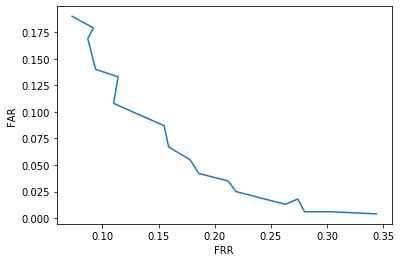

In [70]:
#1. train subject , train subject

counter_true_false_result(0,89, 0,89) 
plt.plot(list_FRR, list_FAR  ) 
#plt.plot(list_FRR, list_FAR ,'bo' ) 

plt.xlabel('FRR') 
plt.ylabel('FAR') 
#plt.legend()
plt.show() 

50 . 
 80.95 % 
 true_result: 1619 false_result: 381 
 TP: 629 FN: 371 FRR: 0.371 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.1905 

52 . 
 82.25 % 
 true_result: 1645 false_result: 355 
 TP: 663 FN: 337 FRR: 0.337 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.17750000000000002 

54 . 
 84.15 % 
 true_result: 1683 false_result: 317 
 TP: 713 FN: 287 FRR: 0.287 
 TN: 970 FP: 30 FAR: 0.03 
 EER: 0.15849999999999997 

56 . 
 86.15 % 
 true_result: 1723 false_result: 277 
 TP: 759 FN: 241 FRR: 0.241 
 TN: 964 FP: 36 FAR: 0.036 
 EER: 0.13849999999999998 

58 . 
 85.95 % 
 true_result: 1719 false_result: 281 
 TP: 767 FN: 233 FRR: 0.233 
 TN: 952 FP: 48 FAR: 0.048 
 EER: 0.1405 

60 . 
 86.5 % 
 true_result: 1730 false_result: 270 
 TP: 794 FN: 206 FRR: 0.206 
 TN: 936 FP: 64 FAR: 0.064 
 EER: 0.135 

62 . 
 86.0 % 
 true_result: 1720 false_result: 280 
 TP: 811 FN: 189 FRR: 0.189 
 TN: 909 FP: 91 FAR: 0.091 
 EER: 0.14 

64 . 
 86.55 % 
 true_result: 1731 false_result: 269 
 TP: 822 FN: 178 FRR: 0.178 
 TN

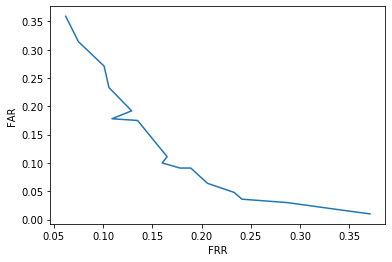

In [72]:
#2. train subject , new subject

counter_true_false_result(0,89, 90,108)
plt.plot(list_FRR, list_FAR )
plt.xlabel('FRR') 
plt.ylabel('FAR') 
#plt.legend()
plt.show()

50 . 
 75.55 % 
 true_result: 1511 false_result: 489 
 TP: 556 FN: 444 FRR: 0.444 
 TN: 955 FP: 45 FAR: 0.045 
 EER: 0.2445 

52 . 
 76.45 % 
 true_result: 1529 false_result: 471 
 TP: 580 FN: 420 FRR: 0.42 
 TN: 949 FP: 51 FAR: 0.051 
 EER: 0.2355 

54 . 
 78.5 % 
 true_result: 1570 false_result: 430 
 TP: 630 FN: 370 FRR: 0.37 
 TN: 940 FP: 60 FAR: 0.06 
 EER: 0.215 

56 . 
 78.15 % 
 true_result: 1563 false_result: 437 
 TP: 640 FN: 360 FRR: 0.36 
 TN: 923 FP: 77 FAR: 0.077 
 EER: 0.2185 

58 . 
 78.6 % 
 true_result: 1572 false_result: 428 
 TP: 668 FN: 332 FRR: 0.332 
 TN: 904 FP: 96 FAR: 0.096 
 EER: 0.21400000000000002 

60 . 
 76.55 % 
 true_result: 1531 false_result: 469 
 TP: 678 FN: 322 FRR: 0.322 
 TN: 853 FP: 147 FAR: 0.147 
 EER: 0.2345 

62 . 
 77.3 % 
 true_result: 1546 false_result: 454 
 TP: 700 FN: 300 FRR: 0.3 
 TN: 846 FP: 154 FAR: 0.154 
 EER: 0.22699999999999998 

64 . 
 77.0 % 
 true_result: 1540 false_result: 460 
 TP: 711 FN: 289 FRR: 0.289 
 TN: 829 FP: 171 F

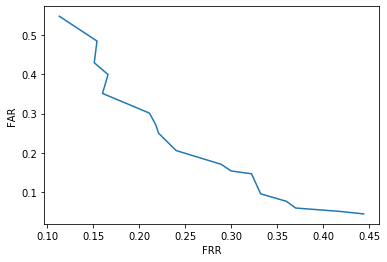

In [74]:
#3. new subject , new subject

counter_true_false_result(90,108, 90,108)
plt.plot(list_FRR, list_FAR )
plt.xlabel('FRR') 
plt.ylabel('FAR') 
#plt.legend()
plt.show()

50 . 
 81.45 % 
 true_result: 1629 false_result: 371 
 TP: 635 FN: 365 FRR: 0.365 
 TN: 994 FP: 6 FAR: 0.006 
 EER: 0.1855 

52 . 
 83.55 % 
 true_result: 1671 false_result: 329 
 TP: 679 FN: 321 FRR: 0.321 
 TN: 992 FP: 8 FAR: 0.008 
 EER: 0.1645 

54 . 
 84.05 % 
 true_result: 1681 false_result: 319 
 TP: 696 FN: 304 FRR: 0.304 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.1595 

56 . 
 83.1 % 
 true_result: 1662 false_result: 338 
 TP: 685 FN: 315 FRR: 0.315 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.169 

58 . 
 86.1 % 
 true_result: 1722 false_result: 278 
 TP: 740 FN: 260 FRR: 0.26 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.139 

60 . 
 85.95 % 
 true_result: 1719 false_result: 281 
 TP: 754 FN: 246 FRR: 0.246 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.1405 

62 . 
 85.7 % 
 true_result: 1714 false_result: 286 
 TP: 760 FN: 240 FRR: 0.24 
 TN: 954 FP: 46 FAR: 0.046 
 EER: 0.143 

64 . 
 87.4 % 
 true_result: 1748 false_result: 252 
 TP: 802 FN: 198 FRR: 0.198 
 TN: 946 FP: 54 FAR: 0.054 
 EER: 0.126 

66 .

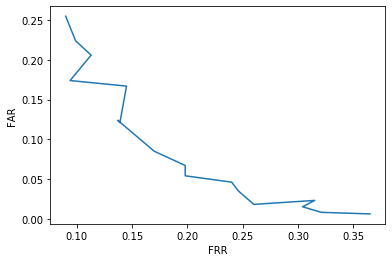

In [77]:
#4. all subject , all subject

counter_true_false_result(0,108, 0,108)
plt.plot(list_FRR, list_FAR )
plt.xlabel('FRR') 
plt.ylabel('FAR') 
#plt.legend()
plt.show()